Premature end of JPEG file


Class distribution (all data): {0: 786, 1: 1621, 2: 786}


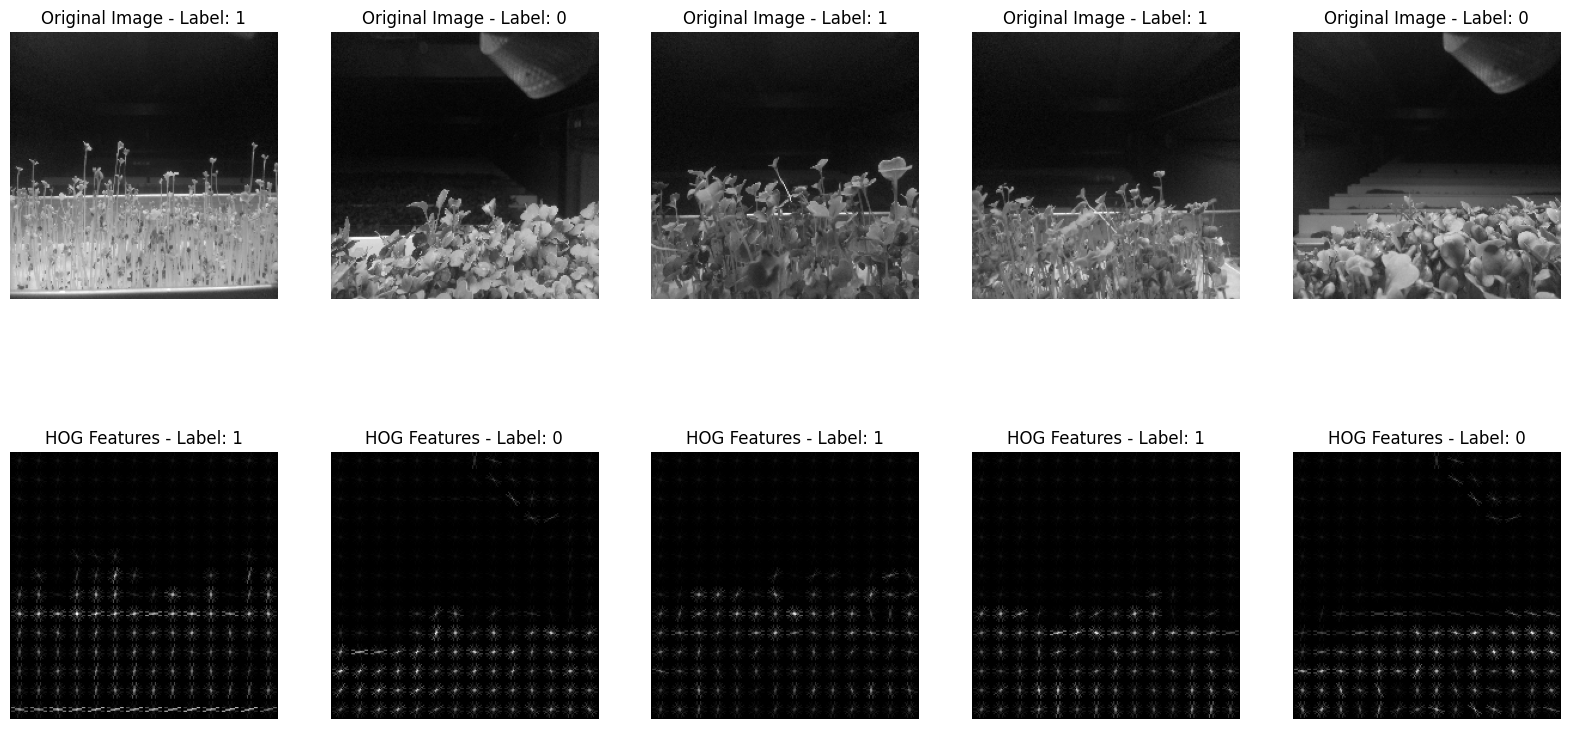

Class distribution (training data): {0: 629, 1: 1296, 2: 629}
Class distribution (test data): {0: 157, 1: 325, 2: 157}
Training fold 1...
Fold 1 accuracy: 0.9178
Training fold 2...
Fold 2 accuracy: 0.9061
Training fold 3...
Fold 3 accuracy: 0.9295
Training fold 4...
Fold 4 accuracy: 0.9100
Training fold 5...
Fold 5 accuracy: 0.9333
Mean cross-validation accuracy: 0.9193
Test set accuracy: 0.9421
Confusion Matrix:
[[146  11   0]
 [ 11 303  11]
 [  0   4 153]]
Classification Report:
              precision    recall  f1-score   support

       Short       0.93      0.93      0.93       157
      Medium       0.95      0.93      0.94       325
        Tall       0.93      0.97      0.95       157

    accuracy                           0.94       639
   macro avg       0.94      0.95      0.94       639
weighted avg       0.94      0.94      0.94       639



<Figure size 1000x700 with 0 Axes>

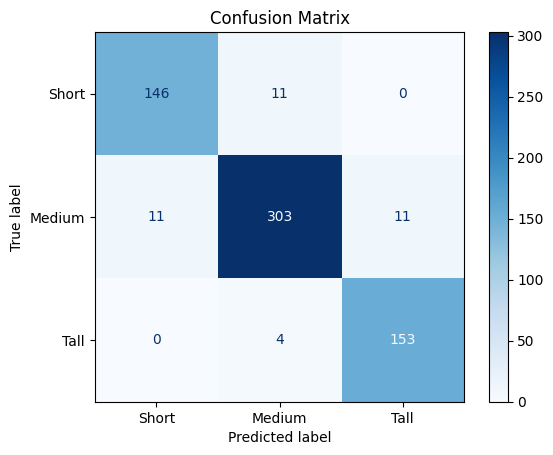

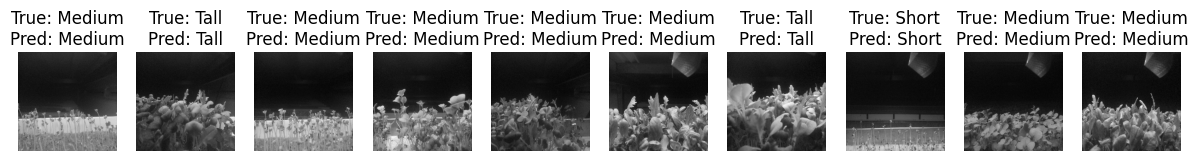

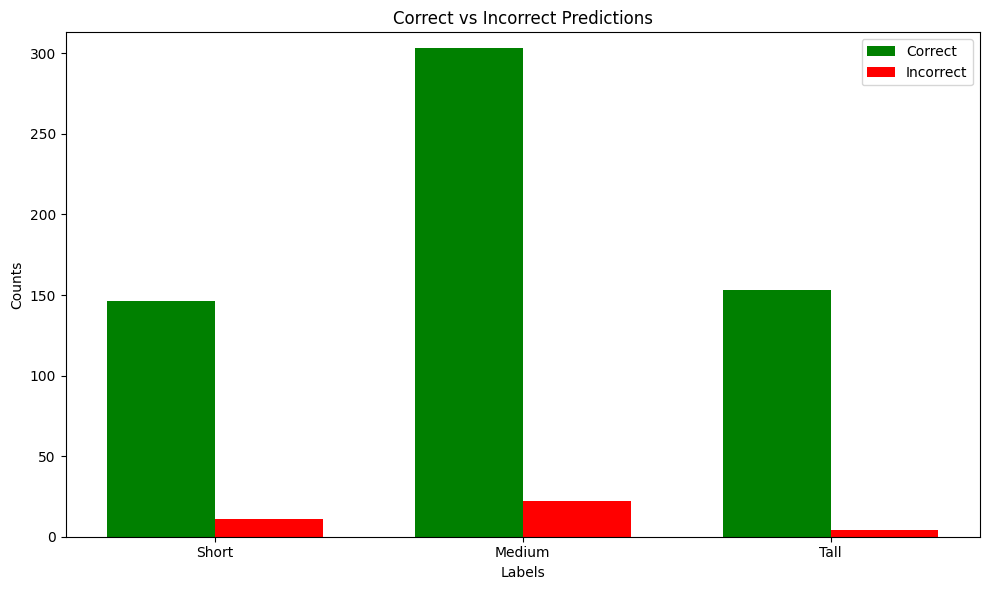

Accuracy with randomized labels: 0.4085


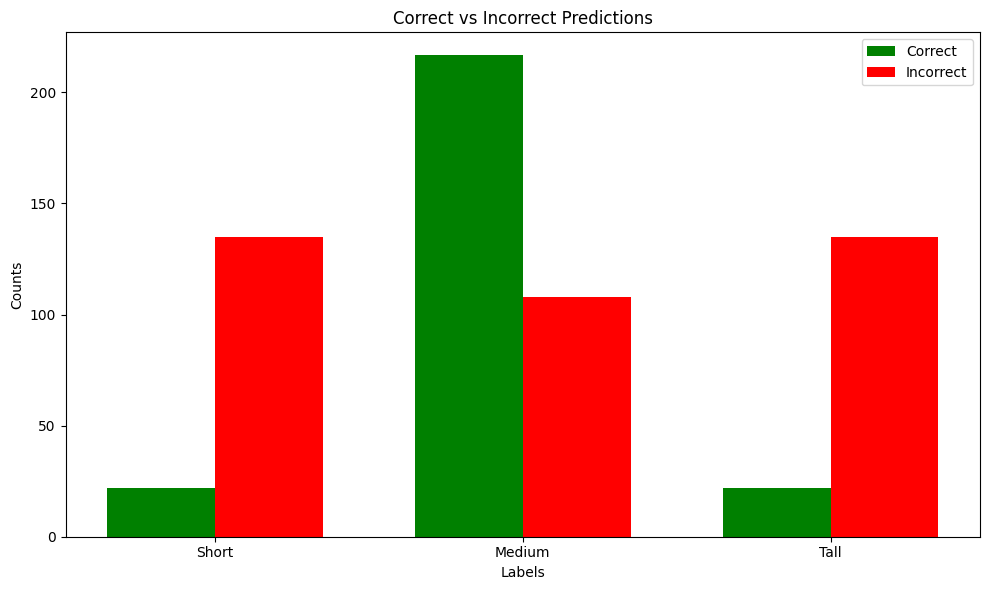

In [1]:
# training script for final side 3-class classification prediction model with 5-fold cv and saving of test results and various metrics

import os
import numpy as np
import cv2
import pandas as pd
import json
from skimage.feature import hog
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
from skimage import exposure
from tqdm import tqdm
import concurrent.futures
import pickle

# Paths to the folders containing the images and height arrays
image_folder = 'bright_spicy_2024/CNN_side_images'
height_folder = 'bright_spicy_2024/CNN_height_arrays'
model_save_path = 'RF_3chp_side_model.pkl'
results_save_path = 'RF_results/3c_side_RF_results.csv'
plot_save_path = 'RF_results/3c_side_RF_cv_plot.png'
test_results_path = 'RF_results/3c_side_RF_test_results.json'
metrics_save_path = 'RF_results/3c_side_RF_metrics.json'
bar_plot_save_path = 'RF_results/3c_side_RF_actual_vs_predicted_bar_plot.png'
random_bar_plot_save_path = 'RF_results/3c_side_randomlabels_RF_actual_vs_predicted_bar_plot.png'

# Best hyperparameters
best_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'trim_bottom': 0.08805012610937063,
    'trim_top': 0.2893423891188367,
    'short_threshold': 748,
    'tall_threshold': 1205
}

def calculate_trimmed_mean(height_array, trim_bottom, trim_top):
    sorted_height_array = np.sort(height_array)
    lower_bound = int(trim_bottom * len(sorted_height_array))
    upper_bound = int((1 - trim_top) * len(sorted_height_array))
    
    if trim_bottom + trim_top >= 1.0:
        raise ValueError("The sum of trim_bottom and trim_top must be less than 1.0")
    
    trimmed_array = sorted_height_array[lower_bound:upper_bound]
    trimmed_mean = np.mean(trimmed_array)
    
    return trimmed_mean

def load_image_and_height(height_file, image_folder, height_folder, trim_bottom, trim_top):
    height_path = os.path.join(height_folder, height_file)
    img_file = height_file.replace('.npy', '.jpg')
    img_path = os.path.join(image_folder, img_file)

    if not os.path.exists(img_path):
        print(f"Image file does not exist: {img_path}")
        return None, None

    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None, None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[:2]
    start_x = (width - 3280) // 2
    start_y = (height - 2464) // 2
    img = img[start_y:start_y + 2464, start_x:start_x + 3280]  # Symmetric crop
    img = cv2.resize(img, (224, 224))

    height_array = np.load(height_path)
    if height_array.size == 0:
        print(f"Height array is empty: {height_path}")
        return None, None

    mean_height = calculate_trimmed_mean(height_array, trim_bottom, trim_top)
    return img, mean_height

def preprocess_data(image_folder, height_folder, trim_bottom, trim_top):
    height_files = [f for f in os.listdir(height_folder) if f.endswith('.npy')]
    images, mean_heights = [], []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(load_image_and_height, height_files, [image_folder]*len(height_files), [height_folder]*len(height_files), [trim_bottom]*len(height_files), [trim_top]*len(height_files)))
    for img, mean_height in results:
        if img is not None and mean_height is not None:
            images.append(img)
            mean_heights.append(mean_height)
    return np.array(images), np.array(mean_heights)

def custom_preprocessing(img):
    img = np.array(img)
    for channel in range(img.shape[2]):
        img[..., channel] = exposure.rescale_intensity(img[..., channel], out_range=(0, 1))
        img[..., channel] = exposure.equalize_hist(img[..., channel])
        img[..., channel] = exposure.equalize_adapthist(img[..., channel], clip_limit=0.03)
    return img

images, mean_heights = preprocess_data(image_folder, height_folder, best_params['trim_bottom'], best_params['trim_top'])
if len(images) == 0 or len(mean_heights) == 0:
    raise ValueError("No images or height arrays were loaded. Please check the data folder and files.")

images = images / 255.0

def label_height_array(mean_height, short_threshold, tall_threshold):
    if mean_height < short_threshold:
        return 'Short'
    elif mean_height > tall_threshold:
        return 'Tall'
    else:
        return 'Medium'

labels = np.array([label_height_array(mean_height, best_params['short_threshold'], best_params['tall_threshold']) for mean_height in mean_heights])
label_map = {'Short': 0, 'Medium': 1, 'Tall': 2}
numerical_labels = np.array([label_map[label] for label in labels])

# Check class distribution
unique, counts = np.unique(numerical_labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution (all data):", class_distribution)

# Extract HOG features
def extract_hog_features(image):
    gray_image = (image * 255).astype(np.uint8)  # Convert to 8-bit unsigned integer
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_RGB2GRAY)
    fd, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=True)
    return fd, hog_image

hog_features, hog_images = zip(*[extract_hog_features(img) for img in images])
hog_features = np.array(hog_features)

# Visualize HOG features for a few sample images with their labels
def visualize_hog_features_with_labels(images, hog_images, labels, num_samples=5):
    plt.figure(figsize=(20, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        hog_img = hog_images[idx]
        label = labels[idx]
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY), cmap='gray')
        plt.title(f'Original Image - Label: {label}')
        plt.axis('off')
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(hog_img, cmap='gray')
        plt.title(f'HOG Features - Label: {label}')
        plt.axis('off')
    plt.show()

visualize_hog_features_with_labels(images, hog_images, numerical_labels)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, numerical_labels, test_size=0.2, stratify=numerical_labels, random_state=42)

# Check class distribution in training and test sets
unique_train, counts_train = np.unique(y_train, return_counts=True)
class_distribution_train = dict(zip(unique_train, counts_train))
print("Class distribution (training data):", class_distribution_train)

unique_test, counts_test = np.unique(y_test, return_counts=True)
class_distribution_test = dict(zip(unique_test, counts_test))
print("Class distribution (test data):", class_distribution_test)

# 5-fold cross-validation setup on training data
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
cv_results = []
fold_metrics = []

for train_index, val_index in kf.split(X_train, y_train):
    print(f"Training fold {fold}...")
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    model = BalancedRandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        sampling_strategy='all',
        replacement=True,
        bootstrap=False,
        random_state=42
    )

    model.fit(X_train_cv, y_train_cv)
    y_pred_val = model.predict(X_val_cv)
    accuracy_val = accuracy_score(y_val_cv, y_pred_val)
    fold_results = {
        'fold': fold,
        'accuracy': accuracy_val
    }
    cv_results.append(accuracy_val)
    fold_metrics.append(fold_results)
    print(f"Fold {fold} accuracy: {accuracy_val:.4f}")
    fold += 1

mean_cv_accuracy = np.mean(cv_results)
print(f"Mean cross-validation accuracy: {mean_cv_accuracy:.4f}")

# Save cross-validation results
cv_results_dict = {
    'fold_accuracies': cv_results,
    'mean_cv_accuracy': mean_cv_accuracy
}
pd.DataFrame(cv_results_dict).to_csv(results_save_path, index=False)

# Save fold metrics
with open(results_save_path.replace('.csv', '_detailed.json'), 'w') as f:
    json.dump(fold_metrics, f)

# Fit final model on all training data
final_model = BalancedRandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    sampling_strategy='all',
    replacement=True,
    bootstrap=False,
    random_state=42
)
final_model.fit(X_train, y_train)

# Save the model
with open(model_save_path, 'wb') as f:
    pickle.dump(final_model, f)

# Evaluate the final model on the test set
y_pred_test = final_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test, target_names=['Short', 'Medium', 'Tall'])

print(f'Test set accuracy: {accuracy_test:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Save metrics
metrics = {
    'accuracy': accuracy_test,
    'confusion_matrix': conf_matrix.tolist(),
    'classification_report': class_report
}
with open(metrics_save_path, 'w') as f:
    json.dump(metrics, f, indent=4)

# Save prediction results
test_results_dict = {
    'y_test': y_test.tolist(),
    'y_pred_test': y_pred_test.tolist()
}
with open(test_results_path, 'w') as f:
    json.dump(test_results_dict, f)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Short', 'Medium', 'Tall'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig(plot_save_path)
plt.show()

# Visualize some predictions
def visualize_predictions(images, true_labels, predicted_labels, label_map, num_samples=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        true_label = true_labels[idx]
        predicted_label = predicted_labels[idx]
        plt.subplot(1, num_samples, i+1)
        plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY), cmap='gray')
        plt.title(f"True: {list(label_map.keys())[true_label]}\nPred: {list(label_map.keys())[predicted_label]}")
        plt.axis('off')
    plt.show()

visualize_predictions(images, numerical_labels, final_model.predict(hog_features), label_map)

# Plot bar plot of actual vs. predicted labels
def plot_bar(y_true, y_pred, label_map, plot_save_path):
    unique_labels = list(label_map.values())
    correct_counts = [np.sum((y_true == label) & (y_pred == label)) for label in unique_labels]
    incorrect_counts = [np.sum((y_true == label) & (y_pred != label)) for label in unique_labels]

    bar_width = 0.35
    index = np.arange(len(unique_labels))

    plt.figure(figsize=(10, 6))
    plt.bar(index, correct_counts, bar_width, label='Correct', color='g')
    plt.bar(index + bar_width, incorrect_counts, bar_width, label='Incorrect', color='r')

    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title('Correct vs Incorrect Predictions')
    plt.xticks(index + bar_width / 2, list(label_map.keys()))
    plt.ylim(0, max(max(correct_counts), max(incorrect_counts)) + 10)  # Ensure y-axis starts at 0
    plt.legend()
    plt.tight_layout()
    plt.savefig(plot_save_path)
    plt.show()

plot_bar(y_test, y_pred_test, label_map, bar_plot_save_path)

# Check for information leakage by randomizing labels
random_labels = np.random.permutation(numerical_labels)
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(hog_features, random_labels, test_size=0.2, stratify=random_labels, random_state=42)

# Train the model on randomized labels
model_random = BalancedRandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    sampling_strategy='all',
    replacement=True,
    bootstrap=False,
    random_state=42
)

model_random.fit(X_train_random, y_train_random)

# Evaluate the model with randomized labels
y_pred_random = model_random.predict(X_test_random)
accuracy_random = accuracy_score(y_test_random, y_pred_random)
print(f'Accuracy with randomized labels: {accuracy_random:.4f}')

# Plot bar plot of actual vs. predicted labels for randomized labels
plot_bar(y_test_random, y_pred_random, label_map, random_bar_plot_save_path)
